In [1]:
from brian2 import *
%matplotlib notebook
prefs.codegen.target = 'numpy'

In [2]:
# Run a 1000 Poisson generators to generate random spikes
poisson = PoissonGroup(3, rates=50*Hz, dt=1*ms)
poisson_spikes = SpikeMonitor(poisson)
net = Network(poisson, poisson_spikes)
net.run(10*second)

# Inject a 50ms pattern repeatedly, with 1/4 probability
pattern_times = poisson_spikes.t[poisson_spikes.t<49.99*ms]
pattern_indices = poisson_spikes.i[poisson_spikes.t<49.99*ms]
pattern_presentations = []
times = []
indices = []
for block in range(400):
    block_time = block*50*ms
    if np.random.rand() < 0.25:
        # use pattern
        pattern_presentations.append(block_time)
        times.extend(block_time + pattern_times)
        indices.extend(pattern_indices)
    else:
        select = (poisson_spikes.t>=block_time) & (poisson_spikes.t<block_time+49.99*ms)
        times.extend(poisson_spikes.t[select])
        indices.extend(poisson_spikes.i[select])
pattern_presentations = Quantity(pattern_presentations)
times = Quantity(times)
indices = Quantity(indices)

In [3]:
# Define a useful plotting function
def do_plot(ax, mon, spike_mon, start, end):
    ax.plot(mon.t/ms, mon.V_m[0]/mV)
    ax.plot(spike_mon.t/ms, np.ones(spike_mon.count[0])*-55, 'rx')
    for presentation in pattern_presentations:
        if presentation >= start-50*ms and presentation <= end+50*ms:
            ax.axvspan(presentation/ms, (presentation + 50*ms)/ms, color='darkgreen', alpha=0.2)
    ax.set_xlim(start/ms, end/ms)
    ax.set(xlabel='time (ms)', ylabel='V (mV)')

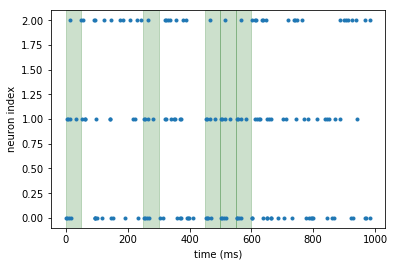

In [4]:
# Plot a few of the spikes
fig, ax = plt.subplots()
select = (times<1*second) & (indices < 100)
ax.plot(times[select]/ms, indices[select], '.')
ax.set(xlabel='time (ms)', ylabel='neuron index')
for presentation in pattern_presentations:
    if presentation > 1*second:
        break
    ax.axvspan(presentation/ms, (presentation + 50*ms)/ms, color='darkgreen', alpha=0.2)

In [5]:
stim = SpikeGeneratorGroup(1000, indices, times)
C_m = 200*pF
E_L = -70*mV
#I = 0.5*nA
g_L = 20*nS
V_th = -55*mV
tau_AMPA = 2.0*ms
E_AMPA = 0*mV

eqs = '''dV_m/dt = (g_L*(E_L - V_m) + g_AMPA*(E_AMPA - V_m))/C_m : volt (unless refractory)
         dg_AMPA/dt = -g_AMPA/tau_AMPA : siemens'''

group = NeuronGroup(1, eqs, threshold='V_m>V_th', reset='V_m=E_L', refractory=3*ms)
group.V_m = E_L

mon = StateMonitor(group, 'V_m', record=0)
spike_mon = SpikeMonitor(group)

# Tutorial begins here...

#syn = Synapses(stim, group, 'w : amp', on_pre='I_syn_post += w') - 1st simple synapse model
g_max = 1.5*nS
dAplus = 0.01*g_max
dAminus = -0.012*g_max
tau = 10*ms

syn = Synapses(stim, group, '''
               w: siemens
               dApre/dt = -Apre/tau : siemens (event-driven)
               dApost/dt = -Apost/tau : siemens (event-driven)''', 
               on_pre = '''g_AMPA_post += w
                           Apre += dAplus
                           w = clip(w + Apost, 0*nS, g_max)''', 
              on_post='''
              Apost += dAminus
              w = clip(w + Apre, 0*nS, g_max)''')


syn.connect()  # All to all connectivity
syn.w = 0.3*nS


net = Network(stim, group, mon, spike_mon, syn)
net.run(15*second, report='text')

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 20. s
7.6132 (38%) simulated in 10s, estimated 16s remaining.
15.341600000000001 (76%) simulated in 20s, estimated 6s remaining.
20.0 (100%) simulated in 26s


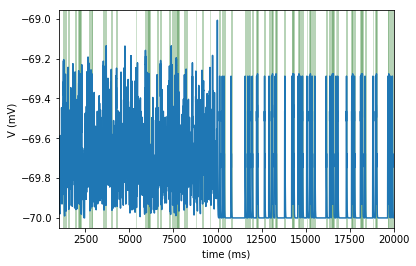

In [8]:
fig, ax = plt.subplots()
do_plot(ax, mon, spike_mon, 1*second, 20*second)